In [1]:
import torch
import pyro
import pyro.distributions as p
from pyro import infer, optim
import random
import matplotlib.pyplot as plt
import seaborn as sns

First lets generate some gaussian data from a multidimensional gaussian 
and we then try to approx. by a mixture of gaussians.

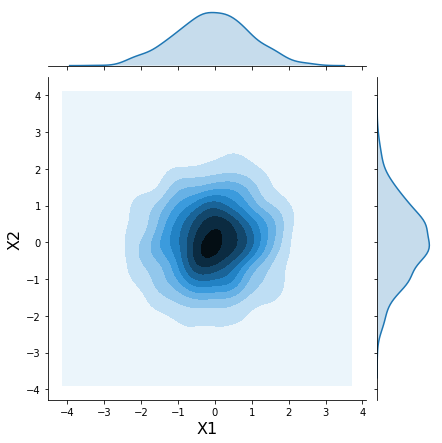

In [2]:
def generate_data(n):
    mu = torch.zeros([2])
    sigma = 1*torch.eye(2)
    data = p.MultivariateNormal(mu, sigma).expand([n]).independent(1).sample()
    return data

data = generate_data(1000)
h = sns.jointplot(data[:, 0], data[:, 1], kind='kde', stat_func=None);
h.set_axis_labels('X1', 'X2', fontsize=16);

So the gaussian mixture model has the following generative model: 
$$ x \sim \prod_i^m \pi_i p_i(x)$$, where $p_i(x) = \mathcal{N}(\mu_i, \sigma_i)$. <br>
So in words: 1) Sample a mixture model according 




#### GMM
- N random variables that are observed, each distributed according to a mixture of K components. 
- N random latent variables specifying the identity of the mixture component of each observation. 

In [3]:
K = 2
N = data.shape[0]

def gmm_model(data = None):
    param_mu = torch.zeros([K])
    param_sigma = torch.ones([K])
    
    weights_param = torch.zeros(K) + 0.1
    weights = pyro.sample('weights', p.Dirichlet(weights_param))
    
    
    with pyro.plate('mixture_hyper', K):
        mu = pyro.sample('mu', p.Normal(param_mu, 1))
        sigma = pyro.sample('sigma', p.Gamma(param_sigma, 1))
            
    with pyro.plate('data', N):
        component_id = pyro.sample('comp_id', p.Categorical(weights))
        sigmas = (sigma.index_select(0, component_id).view(-1,1))*torch.tensor([1.,0.,0.,1.])
        sigmas = sigmas.view(-1,2,2)
        proposed_data = pyro.sample('x', p.MultivariateNormal(mu.index_select(0, component_id).view(-1,1), 
                                            sigmas), obs=data)
    return proposed_data
        

def gmm_guide(data = None):
    weights_param = pyro.param('weights_param' , torch.zeros(K) + 0.1)
    weights = pyro.sample('weights', p.Dirichlet(weights_param))
    
    param_mu = pyro.param('mu_param', torch.zeros([K]))
    param_sigma = pyro.param('sigma_param', torch.ones([K]))
    
    
    with pyro.plate('mixture_hyper', K):
        mu = pyro.sample('mu', p.Normal(param_mu, 1))
        sigma = pyro.sample('sigma', p.Gamma(param_sigma, 1))
            
    with pyro.plate('data', N):
        component_id = pyro.sample('comp_id', p.Categorical(weights))
    

# set up the optimizer
adam_params = {"lr": 0.001 }
optimizer = optim.Adam(adam_params)

# setup the inference algorithm
svi = infer.SVI(gmm_model, gmm_guide, optimizer, loss=infer.Trace_ELBO())

pyro.clear_param_store()

n_steps = 5000
losses = []
mus = []
sigs = []
# do gradient steps
for step in range(n_steps):
    losses.append(svi.step(data))
    mus.append((pyro.get_param_store()['mu_param']))
    sigs.append((pyro.get_param_store()['sigma_param']))
    if random.random() > 0.99:
        #print(f'loss: {losses[-1]}')
        print(f'median: {torch.median(torch.tensor(losses))}')
    

median: 4067.168701171875
median: 4082.0810546875
median: 4085.651123046875
median: 4178.744140625
median: 4170.8466796875
median: 4080.288330078125
median: 4067.1083984375
median: 4064.292236328125
median: 4083.25
median: 4044.83056640625
median: 4036.09619140625
median: 3993.054931640625
median: 3986.1494140625
median: 4008.318603515625
median: 4014.9951171875
median: 4017.44775390625
median: 3977.09765625
median: 3970.3515625
median: 3947.26416015625
median: 3959.61669921875
median: 3959.61669921875
median: 3970.3515625
median: 3975.23388671875
median: 3973.0234375
median: 3955.41162109375
median: 3959.61669921875
median: 3960.085693359375
median: 3950.497802734375
median: 3946.142822265625
median: 3952.2978515625
median: 3950.497802734375
median: 3949.562255859375
median: 3938.40869140625
median: 3927.927001953125
median: 3921.079833984375
median: 3921.079833984375
median: 3915.877197265625
median: 3907.440185546875
median: 3901.0361328125
median: 3894.019287109375
median: 3894.019

Now lets generate data from the proposed distribution and lets check how nice they align

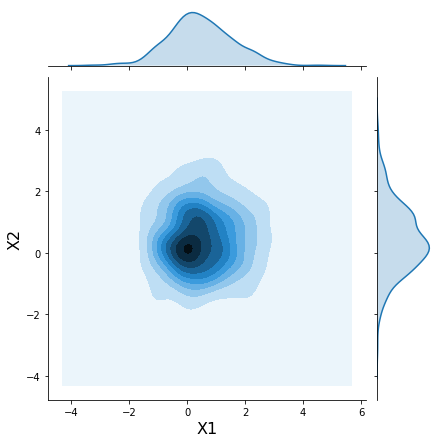

In [4]:
proposed_data = gmm_model()

h = sns.jointplot(proposed_data[:, 0], proposed_data[:, 1], kind='kde', stat_func=None);
h.set_axis_labels('X1', 'X2', fontsize=16);

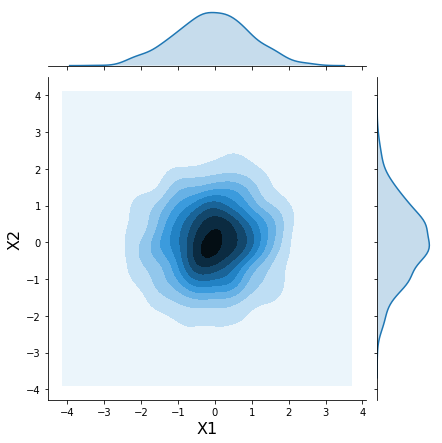

In [5]:
h = sns.jointplot(data[:, 0], data[:, 1], kind='kde', stat_func=None);
h.set_axis_labels('X1', 'X2', fontsize=16);

Definitly not to bad